This notebook is part of the `deepcell-tf` documentation: https://deepcell.readthedocs.io/.

# Training a segmentation model

`deepcell-tf` leverages [Jupyter Notebooks](https://jupyter.org) in order to train models. Example notebooks are available for most model architectures in the [notebooks folder](https://github.com/vanvalenlab/deepcell-tf/tree/master/notebooks). Most notebooks are structured similarly to this example and thus this notebook serves as a core reference for the deepcell approach to model training.

In [1]:
import os
import errno
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.segmentation import relabel_sequential
from IPython.display import HTML

import deepcell
from deepcell.utils.plot_utils import get_js_video
from deepcell.utils.utils_3D import get_3D_cell_statistics, load_mousebrain_data#, tile_predict_watershed
from deepcell_toolbox.deep_watershed import deep_watershed_3D
from deepcell_toolbox.utils import tile_image_3D, untile_image_3D

## Load data

In [2]:
filepath = '/images/data/cells/MouseBrain/3D_annotations/attempt2'
set_nums = 4
test_size = 0.2
seed = 7

X_train, X_test, y_train, y_test = load_mousebrain_data(filepath, set_nums, test_size=test_size, seed=seed)
print('X_train.shape: {}\ty_train.shape: {}'.format(X_train.shape, y_train.shape))
print('X_test.shape: {}\ty_test.shape: {}'.format(X_test.shape, y_test.shape))

X_train.shape: (11, 47, 512, 512, 1)	y_train.shape: (11, 47, 512, 512, 1)
X_test.shape: (3, 47, 512, 512, 1)	y_test.shape: (3, 47, 512, 512, 1)


## Analyze cell statistics

In [3]:
stats = get_3D_cell_statistics(np.concatenate((y_train, y_test), axis=0))

print('Cell dimensions: mean x is {}, mean y is {}, and mean z is {}'.format(
    stats['x_mean'], stats['y_mean'], stats['z_mean']))

Cell dimensions: mean x is 36.07, mean y is 38.4, and mean z is 15.95


## Prepare data

In [4]:
# remove small objects - there are some incorrect annotations of small artifacts
from skimage.morphology import remove_small_objects

small_objects_threshold_init = 50


for i in range(y_train.shape[0]):
    y_train[i, ..., 0] = remove_small_objects(y_train[i, ..., 0].astype(int), min_size=small_objects_threshold_init)

for i in range(y_test.shape[0]):
    y_test[i, ..., 0] = remove_small_objects(y_test[i, ..., 0].astype(int), min_size=small_objects_threshold_init)

In [5]:
# Set args for image tiling
z_dim = 32
xy_dim = 64
tile_shape = (z_dim+1, xy_dim, xy_dim)
stride_train = 0.5
stride_test = 0.5

# Save an untiled version for metrics analysis
X_test_metrics = np.copy(X_test) 
y_test_metrics = np.copy(y_test)

# Tile images into overlapping tiles
X_train, _ = tile_image_3D(X_train, model_input_shape=tile_shape, stride_ratio=stride_train)
X_test, _ = tile_image_3D(X_test, model_input_shape=tile_shape, stride_ratio=stride_test)

y_train, _ = tile_image_3D(y_train, model_input_shape=tile_shape, stride_ratio=stride_train)
y_test, _ = tile_image_3D(y_test, model_input_shape=tile_shape, stride_ratio=stride_test)

print('X_train.shape: {}\ty_train.shape: {}'.format(X_train.shape, y_train.shape))
print('X_test.shape: {}\ty_test.shape: {}'.format(X_test.shape, y_test.shape))

X_train.shape: (4950, 33, 64, 64, 1)	y_train.shape: (4950, 33, 64, 64, 1)
X_test.shape: (1350, 33, 64, 64, 1)	y_test.shape: (1350, 33, 64, 64, 1)


## Set up filepath constants


In [6]:
filename = '--.npz'

DATA_DIR = os.path.expanduser(os.path.join(filepath))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/images'
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Create the PanopticNet Model

Here we instantiate a `PanopticNet` model from `deepcell.model_zoo` using 3 semantic heads:
inner distance (1 class),
outer distance (1 class),
foreground/background distance (2 classes)

In [7]:
temporal_mode = None      # None, 'conv', 'lstm', or 'gru'
frames_per_batch = z_dim

In [8]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[2:],
    frames_per_batch=frames_per_batch, 
    norm_method='std',
    num_semantic_heads=3,
    temporal_mode=temporal_mode,
    num_semantic_classes=[1, 1, 2], # inner distance, outer distance, fgbg
    location=True,  # should always be true
    include_top=True)

W0721 04:39:50.366800 140590699525952 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Prepare for training

### Set up training parameters

In [9]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

# Change these
#model_name = 'mousebrain3D_32x64_TMnone' #best
model_name = 'mousebrain3D_32x64_fillmodewrap'
fill_mode = 'wrap'
n_epoch = 30
batch_size = 1
by_frame_inner = False  # if False, transform inner-distance as 3D, if True transform frame-by-frame
by_frame_outer = True   # if False, transform outer-distance as 3D, if True transform frame-by-frame

# Don't change these
cval = 0
test_size = .20
optimizer = Adam(lr=1e-5, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-5, decay=0.99)
min_objects = 1
model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

### Create the DataGenerators

The `SemanticDataGenerator` can output any number of transformations for each image. These transformations are passed to `generator.flow()` as a list of transform names.

Here we use `"inner-distance"`, `"outer-distance"` and `"fgbg"` to correspond to the inner distance, outer distance, and foreground background semantic heads, respectively. Keyword arguments may also be passed to each transform as a `dict` of transform names to `kwargs`.

In [10]:
from deepcell import image_generators
from deepcell.utils import train_utils

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0, 'by_frame' : by_frame_outer},
                     'inner-distance': {'by_frame' : by_frame_inner}}

# use augmentation for training but not validation
datagen = image_generators.SemanticMovieGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    fill_mode=fill_mode,
    cval=cval,
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticMovieGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    fill_mode=fill_mode,
    cval=cval,
    horizontal_flip=0,
    vertical_flip=0)
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    frames_per_batch=frames_per_batch,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    frames_per_batch=frames_per_batch,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)


W0721 04:44:50.290359 140590699525952 semantic.py:512] Removing 583 of 4950 images with fewer than 1 objects.
W0721 04:46:14.878175 140590699525952 semantic.py:512] Removing 131 of 1350 images with fewer than 1 objects.


Visualize the data generator output.

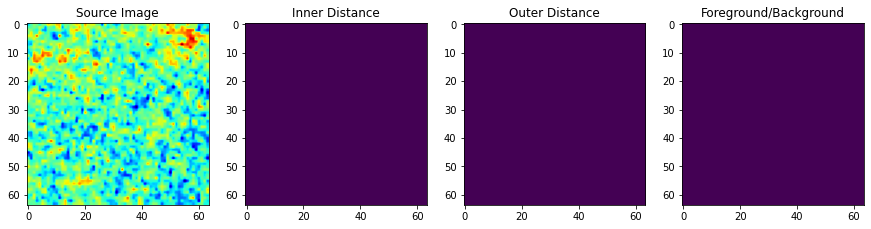

In [11]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

slice=12

axes[0].imshow(img[slice, ..., 0], cmap='jet')
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, slice, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, slice, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, slice, ..., 0])
axes[3].set_title('Foreground/Background')

plt.show()

In [12]:
# Uncomment to see videos of data_generator output

# Inner_distance
#HTML(get_js_video(outputs[0], batch=0, channel=0, interval=500, vmin=0, vmax=outputs[1].max()))

# Outer_distance
# HTML(get_js_video(outputs[1], batch=0, channel=0, interval=500, vmin=0, vmax=outputs[1].max()))

# Raw
# HTML(get_js_video(inputs, batch=0, channel=0, interval=500, vmin=0, vmax=inputs.max()))

### Create a loss function for each semantic head

Each semantic head is trained with it's own loss function. Mean Square Error is used for regression-based heads, whereas `weighted_categorical_crossentropy` is used for classification heads.

The losses are saved as a dictionary and passed to `model.compile`.

In [13]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [14]:
model.compile(loss=loss, optimizer=optimizer)

## Train the model

Call `fit_generator` on the compiled model, along with a default set of callbacks.

In [15]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/30


W0721 04:46:30.095098 140590699525952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


4366/4367 [============================>.] - ETA: 0s - loss: 0.0192 - semantic_0_loss: 0.0086 - semantic_1_loss: 0.0087 - semantic_2_loss: 0.0019
Epoch 00001: val_loss improved from inf to 0.01126, saving model to /images/models/mousebrain3D_32x64_fillmodewrap.h5
4367/4367 [==============================] - 1352s 310ms/step - loss: 0.0192 - semantic_0_loss: 0.0086 - semantic_1_loss: 0.0087 - semantic_2_loss: 0.0019 - val_loss: 0.0113 - val_semantic_0_loss: 0.0058 - val_semantic_1_loss: 0.0042 - val_semantic_2_loss: 0.0013
Epoch 2/30
4366/4367 [============================>.] - ETA: 0s - loss: 0.0114 - semantic_0_loss: 0.0058 - semantic_1_loss: 0.0043 - semantic_2_loss: 0.0014
Epoch 00002: val_loss did not improve from 0.01126
4367/4367 [==============================] - 1277s 292ms/step - loss: 0.0114 - semantic_0_loss: 0.0058 - semantic_1_loss: 0.0043 - semantic_2_loss: 0.0014 - val_loss: 0.0114 - val_semantic_0_loss: 0.0062 - val_semantic_1_loss: 0.0042 - val_semantic_2_loss: 0.0011


4366/4367 [============================>.] - ETA: 0s - loss: 0.0095 - semantic_0_loss: 0.0039 - semantic_1_loss: 0.0031 - semantic_2_loss: 0.0025
Epoch 00018: val_loss did not improve from 0.01126
4367/4367 [==============================] - 1277s 292ms/step - loss: 0.0095 - semantic_0_loss: 0.0039 - semantic_1_loss: 0.0031 - semantic_2_loss: 0.0025 - val_loss: 0.0229 - val_semantic_0_loss: 0.0106 - val_semantic_1_loss: 0.0101 - val_semantic_2_loss: 0.0022
Epoch 19/30
4366/4367 [============================>.] - ETA: 0s - loss: 0.0094 - semantic_0_loss: 0.0038 - semantic_1_loss: 0.0031 - semantic_2_loss: 0.0026
Epoch 00019: val_loss did not improve from 0.01126
4367/4367 [==============================] - 1277s 293ms/step - loss: 0.0094 - semantic_0_loss: 0.0038 - semantic_1_loss: 0.0031 - semantic_2_loss: 0.0026 - val_loss: 0.0241 - val_semantic_0_loss: 0.0114 - val_semantic_1_loss: 0.0109 - val_semantic_2_loss: 0.0018
Epoch 20/30
4366/4367 [============================>.] - ETA: 0s -

KeyboardInterrupt: 

## Predict on test data

Use the trained model to predict on new data. First, create a new prediction model without the foreground background semantic head. While this head is very useful during training, the output is unused during prediction. By using `model.load_weights(path, by_name=True)`, the semantic head can be removed.

In [16]:
# Instantiate prediction model
from deepcell.model_zoo.panopticnet import PanopticNet       
model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[2:],
    frames_per_batch=frames_per_batch,
    norm_method='std',
    num_semantic_heads=2,
    temporal_mode=temporal_mode,
    num_semantic_classes=[1, 1], # inner distance, outer distance
    location=True,  # should always be true
    include_top=True)

In [17]:
# Load weights
model.load_weights(model_path, by_name=True)

In [18]:
def tile_predict_watershed(model,
                           X_test,
                           y_true,
                           input_shape,
                           stride_ratio=0.5,
                           min_distance=10,
                           detection_threshold=0.1,
                           distance_threshold=0.1,
                           small_objects_threshold=0,
                           force_spline=False,
                           spline_power=3,
                           batch_size=1):

    # Tile X_test into overlapping tiles
    X_tiles, tiles_info_X = tile_image_3D(X_test, model_input_shape=input_shape, stride_ratio=stride_ratio)
    
    # Predict on tiles 
    y_pred = model.predict(X_tiles, batch_size=batch_size)

    # Untile predictions
    y_pred = [untile_image_3D(o,
                              tiles_info_X,
                              model_input_shape=input_shape,
                              power=spline_power,
                              force=force_spline) for o in y_pred]
    
    # Run deep_watershed_3D on untiled predictions
    y_pred = deep_watershed_3D(
        y_pred,
        min_distance=min_distance,
        detection_threshold=detection_threshold,
        distance_threshold=distance_threshold,
        exclude_border=False,
        small_objects_threshold=small_objects_threshold)
        
    # Squeeze out channel dimension from y_true
    y_true = np.squeeze(y_true)
    
    # If batch dimension was squeezed out, add it back in
    if y_true.ndim < 4:
        y_true = np.expand_dims(y_true, 0)

    return y_true, y_pred

In [19]:
# Predict on tiles and composite for metrics analysis
input_shape = (frames_per_batch, X_train.shape[2], X_train.shape[3])
stride_ratio = 0.5  
min_distance = 10             # minimum allowable distance between two centroid coords
detection_threshold = 0.1    # absolute threshold for minimum peak intensity
distance_threshold = 0.01      # outer_distance threshold for cell border
batch_size = 1
spline_power = 2
force_spline = False

y_true, y_pred = tile_predict_watershed(model=model,
                                        X_test=X_test_metrics,
                                        y_true=y_test_metrics,
                                        input_shape=input_shape,
                                        stride_ratio=stride_ratio,
                                        min_distance=min_distance,
                                        detection_threshold=detection_threshold,
                                        distance_threshold=distance_threshold,
                                        small_objects_threshold=0,
                                        force_spline=force_spline,
                                        spline_power=spline_power)


print('Shape of y_pred is {} and shape of y_true is {}'.format(y_pred.shape, y_true.shape))

Shape of y_pred is (3, 47, 512, 512) and shape of y_true is (3, 47, 512, 512)


## Run Metrics

In [20]:
#from deepcell_toolbox.metrics import Metrics

#m = Metrics('DeepWatershed - Remove no pixels', seg=False, ndigits=3, cutoff1=0.6, cutoff2=0.1, is_3d=True)
#m.calc_object_stats(y_true, y_pred)

In [21]:
from skimage.morphology import remove_small_objects

small_objects_threshold = 400

# remove small objects - there are some incorrect annotations of very small cells. Should consider removing before training.
for i in range(y_pred.shape[0]):
    y_pred[i] = remove_small_objects(y_pred[i].astype(int), min_size=small_objects_threshold)
    y_true[i] = remove_small_objects(y_true[i].astype(int), min_size=small_objects_threshold)

    y_pred[i], _, _ = relabel_sequential(y_pred[i])

In [22]:
from deepcell_toolbox.metrics import Metrics

m = Metrics('DeepWatershed - Remove no pixels', seg=False, ndigits=3, cutoff1=0.5, cutoff2=0.5, is_3d=True)
m.calc_object_stats(y_true, y_pred)


____________Object-based statistics____________

Number of true cells:		 239
Number of predicted cells:	 235

Correct detections:  223	Recall: 93.305%
Incorrect detections: 12	Precision: 94.894%

Gained detections: 12	Perc Error: 42.857%
Missed detections: 16	Perc Error: 57.143%
Merges: 0		Perc Error: 0.0%
Splits: 0		Perc Error: 0.0%
Catastrophes: 0		Perc Error: 0.0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.754 



In [36]:
from deepcell_toolbox.metrics import Metrics

m = Metrics('DeepWatershed - Remove no pixels', seg=False, ndigits=3, cutoff1=0.5, cutoff2=0.5, is_3d=True)
m.calc_object_stats(y_true, y_pred)


____________Object-based statistics____________

Number of true cells:		 239
Number of predicted cells:	 241

Correct detections:  227	Recall: 94.979%
Incorrect detections: 14	Precision: 94.191%

Gained detections: 14	Perc Error: 53.846%
Missed detections: 12	Perc Error: 46.154%
Merges: 0		Perc Error: 0.0%
Splits: 0		Perc Error: 0.0%
Catastrophes: 0		Perc Error: 0.0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.793 



In [32]:
index = 0
slice = 256

masks = y_pred[index, :, 0:slice, 0:slice]
gt_mask = y_true[index, :, 0:slice, 0:slice]

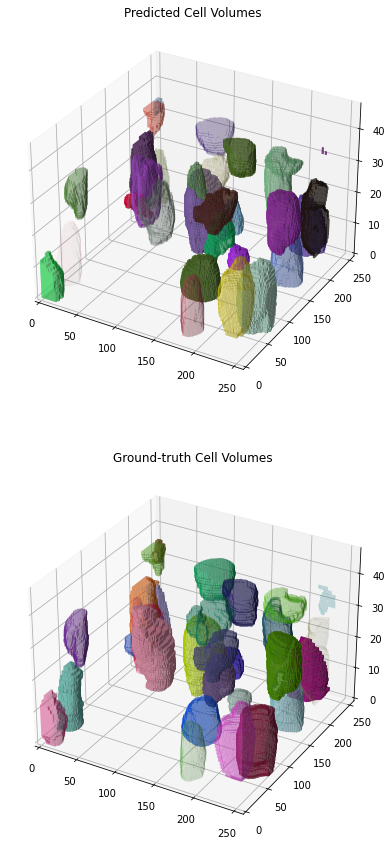

In [34]:
# Plot predicted/true centroids & volumes for one tile 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from skimage.measure import regionprops
#from scipy import ndimage

x_max = slice
y_max = slice

z_min = 0
z_max = 47

fig = plt.figure(figsize=(30, 15))
'''
# Predicted cell volumetric centroid coordinates
coords = peak_local_max(
    np.squeeze(inner_distance[index]),
    min_distance=min_distance,
    threshold_abs=detection_threshold,
    exclude_border=False)


ax = fig.add_subplot(221, projection='3d')
ax.set_xlim3d(0, x_max)
ax.set_ylim3d(0, y_max)
ax.set_zlim3d(z_min, z_max)
test_plot = coords
ax.scatter(test_plot[:, 1], test_plot[:, 2], test_plot[:, 0], c='b', marker='o', s=5)
ax.set_title('Predicted Centroids')

# Ground-truth cell volumetric centroid coordinates
gt_mask = y_test[index+f_mov, ..., 0]
sampling = [0.5, 0.217, 0.217]

gt_dist =  ndimage.distance_transform_edt(gt_mask, sampling=sampling)
gt_dist = gt_dist.astype('float32')
gt_props = regionprops(gt_mask, gt_dist)
gt_coords = []

for cell in gt_props:
    gt_coords.append(np.asarray(cell.weighted_centroid))

gt_coords = np.round(np.asarray(gt_coords))

ax = fig.add_subplot(222, projection='3d')
ax.set_xlim3d(0, x_max)
ax.set_ylim3d(0, y_max)
ax.set_zlim3d(z_min, z_max)
test_plot = gt_coords
ax.scatter(test_plot[:, 1], test_plot[:, 2], test_plot[:, 0], c='b', marker='o', s=5)
ax.set_title('Ground-truth Centroids')
'''


# Predicted Cell volumes
ax = fig.add_subplot(211, projection='3d')
ax.set_xlim3d(0,x_max)
ax.set_ylim3d(0,y_max)
ax.set_zlim3d(z_min, z_max)

plot_masks = np.rollaxis(np.squeeze(masks), 0, 3)

colors = np.empty(plot_masks.shape, dtype='<U9')

color_dict = dict()

for label in np.unique(plot_masks):
    if label != 0:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(8)])]
    else:
        color = None#'#7A88CCC0'

    color_dict[label] = color
    
    colors = np.where(plot_masks==label, color, colors)

ax.voxels(plot_masks, facecolors=colors)
ax.set_title('Predicted Cell Volumes')


# Ground truth Cell Volumes
ax = fig.add_subplot(212, projection='3d')
ax.set_xlim3d(0,x_max)
ax.set_ylim3d(0,y_max)
ax.set_zlim3d(z_min, z_max)

plot_masks = np.rollaxis(np.squeeze(gt_mask), 0, 3)

colors = np.empty(plot_masks.shape, dtype='<U9')

color_dict = dict()

for label in np.unique(plot_masks):
    if label != 0:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(8)])]
    else:
        color = None#'#7A88CCC0'

    color_dict[label] = color
    
    colors = np.where(plot_masks==label, color, colors)

ax.voxels(plot_masks, facecolors=colors)
ax.set_title('Ground-truth Cell Volumes')

plt.show()

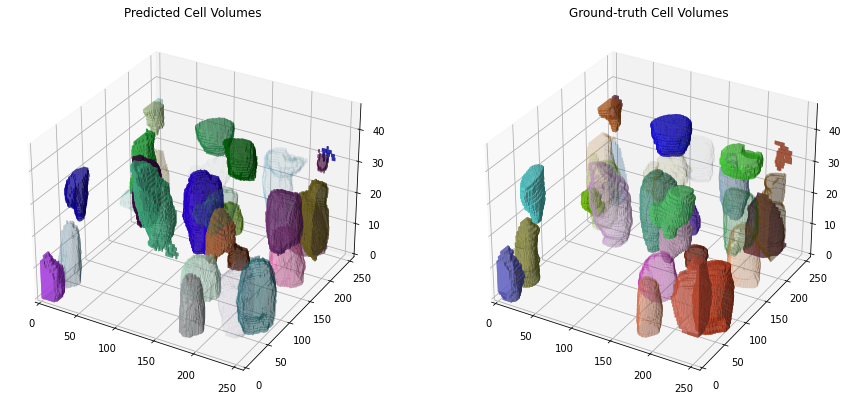